In [27]:
import os
import pandas as pd
import joblib

# -------------------------
# Specify the timestamp of the models to load
# -------------------------
timestamp_to_load = "15:21"  # Change this to your desired timestamp

# -------------------------
# 1. Load the test dataset
# -------------------------
test_file = "/Users/mikael/Documents/ETHZ/Hackathon/Datathon_25/datathon-private/enriched_train.csv"
test_df = pd.read_csv(test_file)

# Ensure your test data contains a unique client identifier column.
if "client_id" not in test_df.columns:
    raise ValueError("The test dataset must have a 'client_id' column.")
client_ids = test_df["client_id"]

# -------------------------
# 2. Define the feature columns used during training
# -------------------------
numerical_features = [
    "aum_savings", "aum_inheritance", "aum_real_estate_value",
    # If embedding was used, include the additional features:
    "pc_1", "pc_2", "pc_3", "pc_4", "pc_5"
]
categorical_features = [
    "inheritance_details_relationship", "investment_risk_profile",
    "investment_horizon", "investment_experience", "currency",
    # Include the names of the rule functions that were appended during training:
    "check_passport_expiry", "RM_contact", "check_inconsistency",
    "check_names", "check_email_name", "check_education_graduation"
]
features = numerical_features + categorical_features

# Check that all required features are present in the test data
missing_features = set(features) - set(test_df.columns)
if missing_features:
    raise ValueError(f"Missing features in test data: {missing_features}")

X_test = test_df[features]

# -------------------------
# 3. Load models for the specified timestamp and generate predictions
# -------------------------
model_folder = "saved_models"
# Model files are assumed to be named as: {model_name}_{timestamp}_model.pkl
model_files = [f for f in os.listdir(model_folder)
               if f.endswith("_model.pkl") and f"_{timestamp_to_load}_" in f]

if not model_files:
    raise FileNotFoundError(f"No model files found with timestamp {timestamp_to_load} in folder {model_folder}.")

predictions = {}

for model_file in model_files:
    model_path = os.path.join(model_folder, model_file)
    model = joblib.load(model_path)
    
    # The pipeline includes preprocessing, so we can directly call predict on X_test.
    preds = model.predict(X_test)
    
    # Extract the model name from the filename.
    # Assuming format: {model_name}_{timestamp}_model.pkl
    model_name = model_file.split("_")[0]
    predictions[model_name] = preds

# -------------------------
# 4. Build and save the prediction DataFrame
# -------------------------
pred_df = pd.DataFrame(predictions, index=client_ids)
pred_df.index.name = "client_id"

output_file = "predictions.csv"
pred_df.to_csv(output_file)
print("Predictions saved to", output_file)
print(pred_df)


ValueError: Missing features in test data: {'aum_real_estate_value', 'currency', 'investment_experience', 'inheritance_details_relationship', 'aum_inheritance', 'investment_horizon', 'investment_risk_profile', 'aum_savings'}

In [16]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score
from sklearn.linear_model import LogisticRegression

In [17]:
seed = 42


np.random.seed(42)

In [18]:
# FAKE DATA

# Number of observations and models
n_obs = 1000
n_models = 20

# Simulate ground truth: assume balanced classes (0/1 with p=0.5)
y_true = np.random.binomial(1, 0.5, n_obs)

# Simulate model predictions:
# Each model has an 80% chance of predicting the correct label.
data = {}
for i in range(1, n_models + 1):
    # For each observation, predict correctly with probability 0.8
    preds = np.where(
        np.random.rand(n_obs) < 0.8,  # 80% chance
        y_true,                      # correct prediction
        1 - y_true                   # incorrect prediction
    )
    data[f'model_{i}'] = preds

# Create DataFrame of predictions
df = pd.DataFrame(data)

In [19]:
# Function: Majority Vote
def majority_vote(df, threshold=0.5):
    """
    Compute majority vote predictions.
    
    Parameters:
      df: DataFrame containing model predictions (each column is a model).
      threshold: float, threshold to decide final vote (default 0.5).
      
    Returns:
      Array of final binary predictions.
    """
    # Average predictions across models (equivalent to fraction of 1's)
    frac_ones = df.mean(axis=1)
    return (frac_ones >= threshold).astype(int)

In [20]:
# Function: Uncertainty Quantification
def uncertainty_quantification(df):
    """
    Quantify uncertainty as the fraction of models that agree with the majority.
    
    Parameters:
      df: DataFrame containing model predictions.
      
    Returns:
      A Series with the agreement fraction per observation.
    """
    # Count how many models predict 1 for each observation
    sum_votes = df.sum(axis=1)
    # Determine agreement as the maximum of (votes for 1, votes for 0) divided by total models
    agreement = np.maximum(sum_votes, n_models - sum_votes) / n_models
    return agreement

In [21]:
# Function: Plot threshold vs. accuracy
def plot_thresholds(df, y_true, thresholds=np.linspace(0, 1, 101)):
    """
    Evaluate and plot accuracy over a range of thresholds for majority voting.
    
    Parameters:
      df: DataFrame containing model predictions.
      y_true: Ground truth labels.
      thresholds: Array of thresholds to test.
    """
    accuracies = []
    for thresh in thresholds:
        preds = majority_vote(df, threshold=thresh)
        acc = accuracy_score(y_true, preds)
        accuracies.append(acc)
    
    plt.figure(figsize=(8, 5))
    plt.plot(thresholds, accuracies, marker='o')
    plt.xlabel("Threshold")
    plt.ylabel("Accuracy")
    plt.title("Majority Vote Accuracy vs. Threshold")
    plt.grid(True)
    plt.show()

In [23]:
# Function: Learn weighted average using logistic regression
def learn_weighted_average(df, y_true):
    """
    Learn a weighted ensemble of model predictions via logistic regression.
    
    Parameters:
      df: DataFrame containing model predictions.
      y_true: Ground truth labels.
      
    Returns:
      Trained logistic regression model and predicted probabilities.
    """
    # Initialize and fit logistic regression using the model predictions as features
    model = LogisticRegression(solver='lbfgs', max_iter=1000)
    model.fit(df, y_true)
    
    # Get predicted probabilities for class 1
    weighted_preds = model.predict_proba(df)[:, 1]
    
    # Display learned coefficients for each model (weight)
    weights = pd.Series(model.coef_[0], index=df.columns)
    print("Learned Weights for each model:")
    print(weights.sort_values(ascending=False))
    
    return model, weighted_preds

Accuracy using majority vote (threshold=0.5): 0.998

Agreement fraction (first 10 observations):
0    0.85
1    0.95
2    0.65
3    0.95
4    0.75
5    0.65
6    0.85
7    0.70
8    0.95
9    0.90
dtype: float64


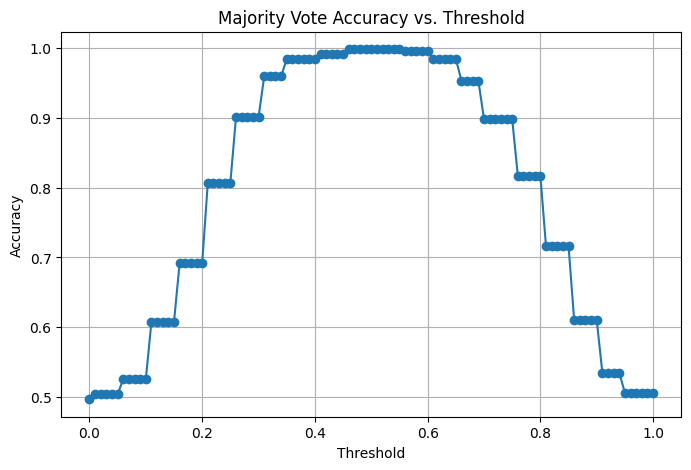

Learned Weights for each model:
model_15    1.427564
model_5     1.377070
model_14    1.367094
model_4     1.341004
model_3     1.339408
model_13    1.308370
model_9     1.248661
model_20    1.156906
model_16    1.140034
model_7     1.126577
model_10    1.125060
model_12    1.116182
model_2     1.081258
model_17    1.057412
model_18    1.036680
model_1     0.990183
model_19    0.892626
model_8     0.865632
model_6     0.852482
model_11    0.588677
dtype: float64

Accuracy using weighted average (threshold=0.5): 1.0


In [24]:
# --- Run the functions ---

# 1. Majority Vote (using default threshold 0.5)
mv_predictions = majority_vote(df)
print("Accuracy using majority vote (threshold=0.5):",
      accuracy_score(y_true, mv_predictions))

# 2. Uncertainty Quantification
agreement_fraction = uncertainty_quantification(df)
print("\nAgreement fraction (first 10 observations):")
print(agreement_fraction.head(10))

# 3. Plot accuracy vs. threshold
plot_thresholds(df, y_true)

# 4. Learn weighted average using logistic regression
model, weighted_preds = learn_weighted_average(df, y_true)
print("\nAccuracy using weighted average (threshold=0.5):",
      accuracy_score(y_true, (weighted_preds >= 0.5).astype(int)))

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score
from sklearn.linear_model import LogisticRegression

# Set seed for reproducibility
np.random.seed(42)

# Number of observations and models
n_obs = 1000
n_models = 20

# Simulate ground truth: assume balanced classes (0/1 with p=0.5)
y_true = np.random.binomial(1, 0.5, n_obs)

# Simulate model predictions:
# Each model has an 80% chance of predicting the correct label.
data = {}
for i in range(1, n_models + 1):
    # For each observation, predict correctly with probability 0.8
    preds = np.where(
        np.random.rand(n_obs) < 0.8,  # 80% chance
        y_true,                      # correct prediction
        1 - y_true                   # incorrect prediction
    )
    data[f'model_{i}'] = preds

# Create DataFrame of predictions
df = pd.DataFrame(data)

# Function: Majority Vote
def majority_vote(df, threshold=0.5):
    """
    Compute majority vote predictions.
    
    Parameters:
      df: DataFrame containing model predictions (each column is a model).
      threshold: float, threshold to decide final vote (default 0.5).
      
    Returns:
      Array of final binary predictions.
    """
    # Average predictions across models (equivalent to fraction of 1's)
    frac_ones = df.mean(axis=1)
    return (frac_ones >= threshold).astype(int)

# Function: Uncertainty Quantification
def uncertainty_quantification(df):
    """
    Quantify uncertainty as the fraction of models that agree with the majority.
    
    Parameters:
      df: DataFrame containing model predictions.
      
    Returns:
      A Series with the agreement fraction per observation.
    """
    # Count how many models predict 1 for each observation
    sum_votes = df.sum(axis=1)
    # Determine agreement as the maximum of (votes for 1, votes for 0) divided by total models
    agreement = np.maximum(sum_votes, n_models - sum_votes) / n_models
    return agreement

# Function: Plot threshold vs. accuracy
def plot_thresholds(df, y_true, thresholds=np.linspace(0, 1, 101)):
    """
    Evaluate and plot accuracy over a range of thresholds for majority voting.
    
    Parameters:
      df: DataFrame containing model predictions.
      y_true: Ground truth labels.
      thresholds: Array of thresholds to test.
    """
    accuracies = []
    for thresh in thresholds:
        preds = majority_vote(df, threshold=thresh)
        acc = accuracy_score(y_true, preds)
        accuracies.append(acc)
    
    plt.figure(figsize=(8, 5))
    plt.plot(thresholds, accuracies, marker='o')
    plt.xlabel("Threshold")
    plt.ylabel("Accuracy")
    plt.title("Majority Vote Accuracy vs. Threshold")
    plt.grid(True)
    plt.show()

# Function: Learn weighted average using logistic regression
def learn_weighted_average(df, y_true):
    """
    Learn a weighted ensemble of model predictions via logistic regression.
    
    Parameters:
      df: DataFrame containing model predictions.
      y_true: Ground truth labels.
      
    Returns:
      Trained logistic regression model and predicted probabilities.
    """
    # Initialize and fit logistic regression using the model predictions as features
    model = LogisticRegression(solver='lbfgs', max_iter=1000)
    model.fit(df, y_true)
    
    # Get predicted probabilities for class 1
    weighted_preds = model.predict_proba(df)[:, 1]
    
    # Display learned coefficients for each model (weight)
    weights = pd.Series(model.coef_[0], index=df.columns)
    print("Learned Weights for each model:")
    print(weights.sort_values(ascending=False))
    
    return model, weighted_preds

# --- Run the functions ---

# 1. Majority Vote (using default threshold 0.5)
mv_predictions = majority_vote(df)
print("Accuracy using majority vote (threshold=0.5):",
      accuracy_score(y_true, mv_predictions))

# 2. Uncertainty Quantification
agreement_fraction = uncertainty_quantification(df)
print("\nAgreement fraction (first 10 observations):")
print(agreement_fraction.head(10))

# 3. Plot accuracy vs. threshold
plot_thresholds(df, y_true)

# 4. Learn weighted average using logistic regression
model, weighted_preds = learn_weighted_average(df, y_true)
print("\nAccuracy using weighted average (threshold=0.5):",
      accuracy_score(y_true, (weighted_preds >= 0.5).astype(int)))
